In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fsmodels import SklMultiExpFrequencyScan

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# sklearn-compatible class

https://scikit-learn.org/stable/developers/develop.html

https://scikit-learn.org/stable/glossary.html#glossary

In [2]:
frequency_powers = np.linspace(0, 3.5, 1000)
frequency_powers = tf.Variable(frequency_powers, dtype='float64').numpy()

In [3]:
fs = SklMultiExpFrequencyScan(n_exps=3, filling_pulse=20*10**-6)

fs.exps_params_ = [[-1.0, 3.5],
                  [-2.3, 3.0],
                  [-3.5, 2.5]]

experimental_dlts = fs.predict(frequency_powers) 
experimental_dlts += np.random.normal(loc=0, scale=0.2, size=experimental_dlts.shape[0])

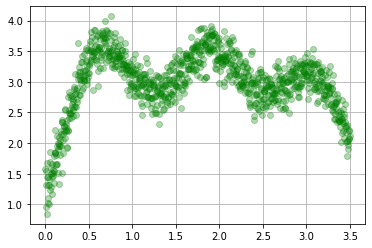

In [4]:
plt.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3)
plt.grid()
plt.show()

In [5]:
n_exps = 3

fs = SklMultiExpFrequencyScan(n_exps=n_exps, 
                           filling_pulse=2*10**-5,
                           n_iters=200,
                           stop_val=10**-5,
                           verbose=True
                          )

fs.fit(X=frequency_powers, y=experimental_dlts)

iter # 0
exps_params:
 [[-2.0147081   1.        ]
 [-2.40554175  1.        ]
 [-2.66391691  1.        ]]
Loss: 4.354529585089708


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
fit_results = fs.fit_results_
fit_results

In [ ]:
fs.exps_params_

In [ ]:
def plot_ident_res(frequency_powers,
                   experimental_dlts, 
                   fit_results
                  ):
    
    indices = frequency_powers.argsort()
    frequency_powers = frequency_powers[indices]
    experimental_dlts = experimental_dlts[indices]
    
    n_exps=fit_results.loc[0, 'n_exps']
    
    init_params = fit_results.iloc[0, :]
    init_params = [[init_params[f'time_constant_power_{i}'], init_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs = SklMultiExpFrequencyScan(n_exps=n_exps, filling_pulse = fit_results.filling_pulse[0])
    fs.exps_params_ = init_params
    
    initial_model = fs.predict(frequency_powers)
    
    
    final_params = fit_results.iloc[-1, :]
    final_params = [[final_params[f'time_constant_power_{i}'], final_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs.exps_params_=final_params
    final_model = fs.predict(frequency_powers)
    

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3, label='Экспериментальные данные')

    ax.plot(frequency_powers, initial_model, '-b', label='Начальная модель')

    ax.plot(frequency_powers, final_model, '-r', label='Модель после идентификации')

    for i, scan in enumerate(fs._fs_list):
        plt.plot(frequency_powers, scan(frequency_powers), '-.', label=f'exp{i}')

    ax.legend()
    ax.grid()
    ax.set_xlim([0, 3.5])
    ylim = ax.get_ylim()
    ylim = [np.floor(ylim[0]), np.ceil(ylim[1])]
    ax.set_ylim(ylim)
    
    ax.set_title('Результаты идентификации')
    ax.set_xlabel(r'$\log_{10}(F_0), \log_{10}(Гц)$')
    ax.set_ylabel('Сигнал DLTS, условные единицы')
    
    return fig, ax



fig, ax = plot_ident_res(frequency_powers,
                         experimental_dlts, 
                         fit_results
                        )

plt.show()

In [ ]:
fs.get_params()

In [ ]:
fs.set_params(n_exps=4)

In [ ]:
fs.get_params()

In [ ]:
fs.score(X=frequency_powers, y=experimental_dlts)

In [ ]:
fs.predict(X=frequency_powers)

In [ ]:
fit_results.loss.plot()

# K-fold Cross-Validation and hyperparameter tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(frequency_powers, experimental_dlts, test_size=0.2)

In [ ]:
plt.plot(X_train, y_train, 'og', alpha=0.3)
plt.grid()
plt.show()

In [ ]:
plt.plot(X_test, y_test, 'og', alpha=0.3)
plt.grid()
plt.show()

In [ ]:
fs = SklMultiExpFrequencyScan(n_exps=2,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

In [ ]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

In [ ]:
fs.fit_results_

In [ ]:
fit_results = fs.fit_results_

fig, ax = plot_ident_res(X_train,
                         y_train, 
                         fit_results
                        )

plt.show()

In [ ]:
fs = SklMultiExpFrequencyScan(n_exps=5,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

In [ ]:
grid_search = GridSearchCV(fs, {'n_exps':[2,3,4,5]}, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

In [ ]:
fit_results = grid_search.best_estimator_.fit_results_

fig, ax = plot_ident_res(X_train,
                         y_train, 
                         fit_results
                        )

plt.show()

In [ ]:
mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test), squared=False)